In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import VarianceThreshold
import numpy as np
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot as plt
from utility import *
import xgboost as xgb

In [2]:
base = "/Users/claxl/Documents/GitHub/MLProject/Data Exploration/EDA/clearData/"

In [28]:
df_train_est_A, df_train_obs_A, df_test_A = readData(base,1)
df_train_est_B, df_train_obs_B, df_test_B = readData(base,2)
df_train_est_C, df_train_obs_C, df_test_C = readData(base,3)

In [29]:
df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)

df_train_est_B.set_index('date_forecast', inplace=True)
df_train_obs_B.set_index('date_forecast', inplace=True)
df_test_B.set_index('date_forecast', inplace=True)

df_train_est_C.set_index('date_forecast', inplace=True)
df_train_obs_C.set_index('date_forecast', inplace=True)
df_test_C.set_index('date_forecast', inplace=True)

In [52]:
df_train_A = get_df_train(df_train_est_A,df_train_obs_A)
df_train_B = get_df_train(df_train_est_B,df_train_obs_B)
df_train_C = get_df_train(df_train_est_C,df_train_obs_C)
df_train = get_df_train(df_train_A,df_train_B)

df_train = get_df_train(df_train,df_train_C)

df_test = df_test_A
df_train.shape

(99014, 46)

In [53]:
features_name = [c for c in df_train.columns if c != 'pv_measurement']
target = 'pv_measurement'
X = df_train_A[features_name]
y = df_train_A[target]
X_test = df_test[features_name]
X.shape,y.shape,X_test.shape

((34061, 45), (34061,), (720, 45))

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, shuffle = False)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((30654, 45), (3407, 45), (30654,), (3407,))

In [76]:
X_train.dtypes

absolute_humidity_2m:gm3          float64
air_density_2m:kgm3               float64
ceiling_height_agl:m              float64
clear_sky_energy_1h:J             float64
clear_sky_rad:W                   float64
cloud_base_agl:m                  float64
dew_or_rime:idx                   float64
dew_point_2m:K                    float64
diffuse_rad:W                     float64
diffuse_rad_1h:J                  float64
direct_rad:W                      float64
direct_rad_1h:J                   float64
effective_cloud_cover:p           float64
elevation:m                       float64
fresh_snow_12h:cm                 float64
fresh_snow_1h:cm                  float64
fresh_snow_24h:cm                 float64
fresh_snow_3h:cm                  float64
fresh_snow_6h:cm                  float64
is_day:idx                        float64
is_in_shadow:idx                  float64
msl_pressure:hPa                  float64
precip_5min:mm                    float64
precip_type_5min:idx              

## 1. Univariate Analysis

In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

NUMBER_FEATURES = 12

for tmp in [f_regression, mutual_info_regression]:
    print('-------------------------------------------------------------------')
    bestfeatures = SelectKBest(score_func=tmp, k=NUMBER_FEATURES)
    fit = bestfeatures.fit(X_train, np.ravel(Y_train))
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_train.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    print(featureScores.nlargest(NUMBER_FEATURES,'Score')) 

-------------------------------------------------------------------
                          Specs         Score
10                 direct_rad:W  82037.054333
11              direct_rad_1h:J  67048.001968
4               clear_sky_rad:W  56129.309194
3         clear_sky_energy_1h:J  48258.186326
8                 diffuse_rad:W  30714.644782
9              diffuse_rad_1h:J  28117.415010
36              sun_elevation:d  27719.717887
20             is_in_shadow:idx  15200.213785
19                   is_day:idx  12588.279615
28  relative_humidity_1000hPa:p   4770.603730
1           air_density_2m:kgm3   4739.144875
38                  t_1000hPa:K   4009.611883
-------------------------------------------------------------------
                    Specs     Score
36        sun_elevation:d  0.912654
4         clear_sky_rad:W  0.839755
8           diffuse_rad:W  0.815383
3   clear_sky_energy_1h:J  0.745455
10           direct_rad:W  0.743599
9        diffuse_rad_1h:J  0.706779
11        dire

Information gain, evaluation the information gain of each variable in the context of the target variable

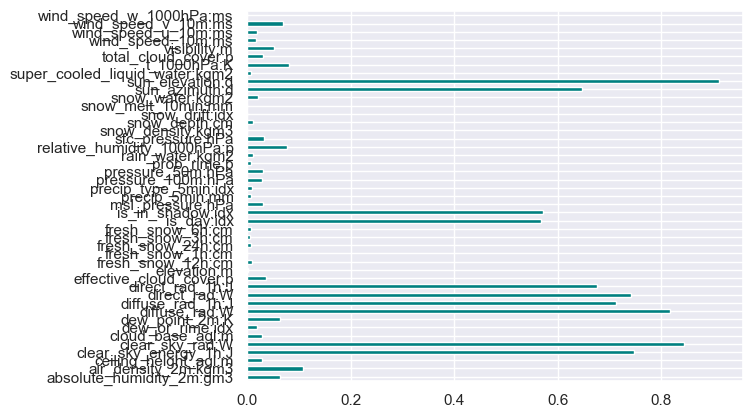

In [62]:
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_regression(X_train, np.ravel(Y_train))
feat_importances = pd.Series(importances, X_train.columns)
feat_importances.plot(kind='barh', color='teal')
plt.show()

Feature with higher variance may contain more useful information

In [63]:
from sklearn.feature_selection import VarianceThreshold

v_threshold = VarianceThreshold(threshold=0)
v_threshold.fit(X_train)
v_threshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Mean Absolute Difference, the higher the MAD is, the higher is discriminatory power

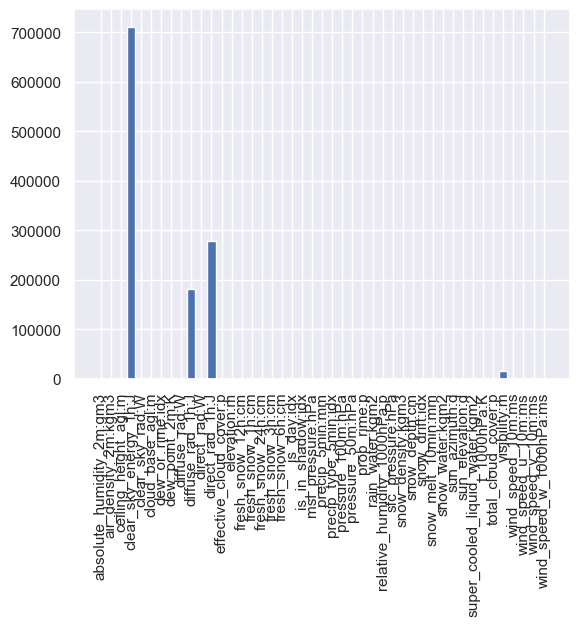

In [68]:
mean_abs_diff = np.sum(np.abs(X_train - np.mean(X_train, axis=0)), axis=0)/X_train.shape[0]
plt.bar(X_train.columns, mean_abs_diff)
plt.xticks(rotation = 90)
plt.show()

Dispersion ratio, the higher it is, the more relevant the feature is

C:\Users\claxl\anaconda3\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


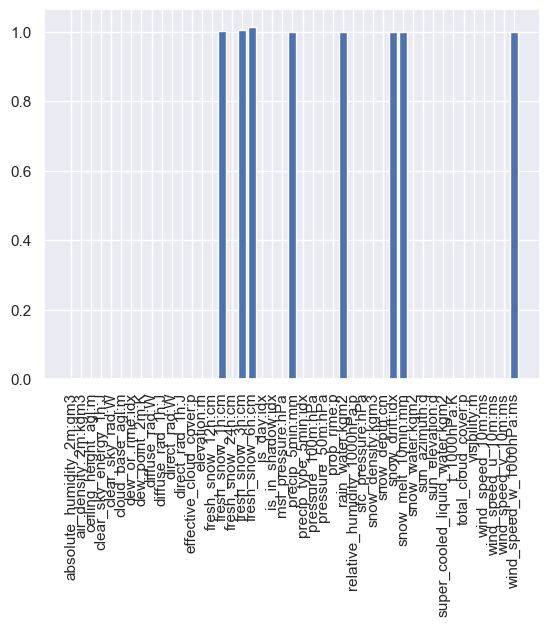

In [67]:
X = X_train + 1
am = np.mean(X, axis=0)
gm = np.power(np.prod(X, axis=0), 1/X.shape[0])
disp_ratio = am/gm
plt.bar(X.columns, disp_ratio)
plt.xticks(rotation = 90)
plt.show()

## 2. Feature Importance

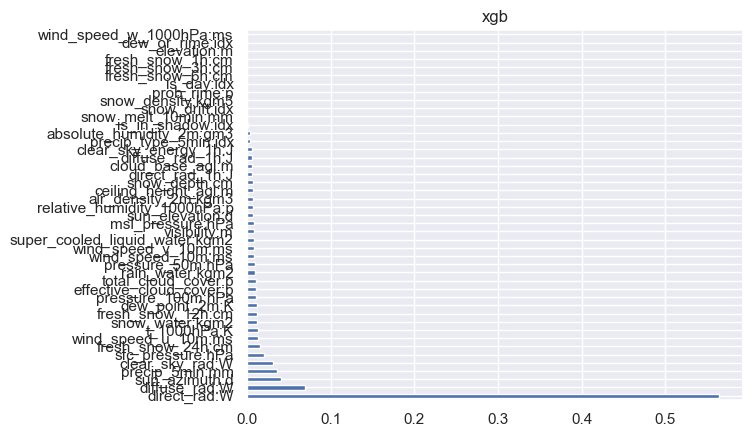

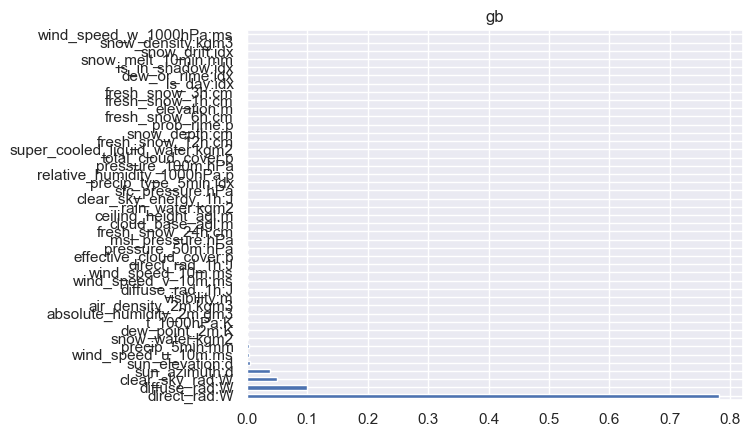

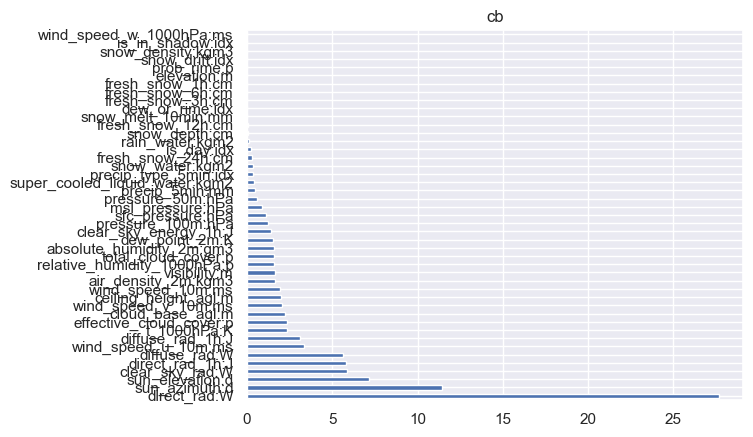

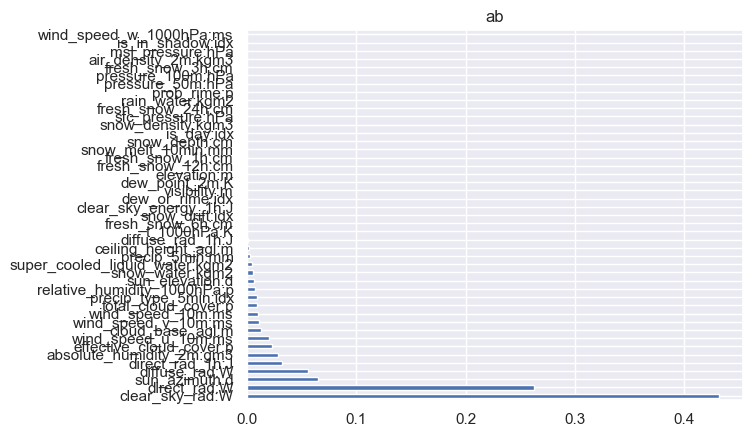

In [77]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
SEED = 42
models = {
   # 'rf': RandomForestRegressor(random_state=SEED,),
   # 'lgbm': LGBMRegressor(),
    'xgb': XGBRegressor(random_state=SEED,),
    'gb': GradientBoostingRegressor(random_state=SEED,),
    'cb': CatBoostRegressor(random_state=SEED, silent=True),
    'ab': AdaBoostRegressor(random_state=SEED,),
}

for key in models:
    plt.title(key)
    model = models[key]
    model.fit(X_train, np.ravel(Y_train))
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(X_train.shape[0]).plot(kind='barh')
    plt.show()